#  Recurrent PG Crypto-Currency Trading

In [1052]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib.finance as mpf
from matplotlib.pylab import date2num
from HuobiServices import *
from DataUtils import *
import talib
import tensorflow as tf
from tqdm import tqdm
import seaborn as sns
import os
%matplotlib inline

In [6]:
lmap=lambda func,it: list(map(lambda x:func(x),it))
lfilter=lambda func,it: list(filter(lambda x:func(x),it))
z_score=lambda x:(x-np.mean(x,axis=0))/(np.std(x,axis=0)+1e-5)

In [1005]:
class RPG_Crypto_portfolio(object):
    def __init__(self, feature_number, action_size=1, hidden_units_number=[128, 64], learning_rate=0.001):
        tf.reset_default_graph()
        self.s = tf.placeholder(dtype=tf.float32, shape=[None, feature_number], name='s')
        self.a = tf.placeholder(dtype=tf.int32, shape=[None,action_size], name='a')
        self.r = tf.placeholder(dtype=tf.float32, shape=[None], name='r')
        self.s_next=tf.placeholder(dtype=tf.float32, shape=[None, feature_number], name='s_next')
        self.action_size=action_size
        self.a_buffer = []
        self.r_buffer = []
        self.s_buffer = []
        self.s_next_buffer=[]
        self.dropout_keep_prob = tf.placeholder(dtype=tf.float32, shape=[], name='dropout_keep_prob')
        with tf.variable_scope('rnn_encoder', initializer=tf.contrib.layers.xavier_initializer(uniform=True), regularizer=tf.contrib.layers.l2_regularizer(0.01)):
            cell=self._add_GRU(units_number=128,keep_prob=self.dropout_keep_prob)
#             cells=self._add_GRUs(units_number=[256,128],activation=[tf.nn.relu,tf.nn.tanh])
            self.rnn_input=tf.expand_dims(self.s,axis=0)
            self.rnn_output,_=tf.nn.dynamic_rnn(inputs=self.rnn_input,cell=cell,dtype=tf.float32)
#             self.rnn_output=tf.contrib.layers.layer_norm(self.rnn_output)
            self.rnn_output=tf.unstack(self.rnn_output,axis=0)[0]
            
        with tf.variable_scope('supervised',initializer=tf.contrib.layers.xavier_initializer(uniform=True), regularizer=tf.contrib.layers.l2_regularizer(0.01)):
            self.state_predict = self._add_dense_layer(inputs=self.rnn_output, output_shape=hidden_units_number, drop_keep_prob=self.dropout_keep_prob, act=tf.nn.relu, use_bias=True)
            self.state_predict = self._add_dense_layer(inputs=self.rnn_output, output_shape=[feature_number], drop_keep_prob=self.dropout_keep_prob, act=None, use_bias=True)
            self.state_loss=tf.losses.mean_squared_error(self.state_predict,self.s_next)
            
        with tf.variable_scope('policy_gradient',initializer=tf.contrib.layers.xavier_initializer(uniform=True), regularizer=tf.contrib.layers.l2_regularizer(0.01)):
#             self.rnn_output=tf.stop_gradient(self.rnn_output)
            self.a_prob = self._add_dense_layer(inputs=self.rnn_output, output_shape=hidden_units_number+[action_size], drop_keep_prob=self.dropout_keep_prob, act=tf.nn.relu, use_bias=True)
#             self.a_prob = self._add_dense_layer(inputs=self.a_prob, output_shape=, drop_keep_prob=self.dropout_keep_prob, act=None, use_bias=True)
            self.a_out = tf.nn.softmax(self.a_prob,axis=-1)
            self.negative_cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=self.a_prob, labels=self.a)
            
        with tf.variable_scope('train'):
            optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            self.loss = tf.reduce_mean(self.negative_cross_entropy * self.r)+tf.reduce_mean(self.state_loss)
            self.train_op = optimizer.minimize(self.loss)
        self.init_op = tf.global_variables_initializer()
        self.session = tf.Session()
        self.saver = tf.train.Saver()
    def init_model(self):
        self.session.run(self.init_op)
    
    def _add_dense_layer(self, inputs, output_shape, drop_keep_prob, act=tf.nn.relu, use_bias=True):
        output = inputs
        for n in output_shape:
            output = tf.layers.dense(output, n, activation=act, use_bias=use_bias)
            output = tf.nn.dropout(output, drop_keep_prob)
        return output
    
    def _add_GRU(self,units_number,activation=tf.nn.relu,keep_prob=1.0):
        cell = tf.contrib.rnn.LSTMCell(units_number,activation=activation)
        cell = tf.contrib.rnn.DropoutWrapper(cell, input_keep_prob=keep_prob)
        return cell
    
    def _add_GRUs(self,units_number,activation,keep_prob=1.0):
        cells=tf.contrib.rnn.MultiRNNCell(cells=[ self._add_GRU(units_number=n,activation=a) for n,a in zip(units_number,activation)])
        return cells
    
    def _add_gru_cell(self, units_number, activation=tf.nn.relu):
        return tf.contrib.rnn.GRUCell(num_units=units_number, activation=activation)
    
    def train(self, drop=0.85):
#         np.random.shuffle(random_index)
        feed = {
            self.a: np.array(self.a_buffer),
            self.r: np.array(self.r_buffer),
            self.s: np.array(self.s_buffer),
            self.s_next:np.array(self.s_next_buffer),
            self.dropout_keep_prob: drop
        }
        _, loss = self.session.run([self.train_op, self.loss], feed_dict=feed)
        return loss
    
    def restore_buffer(self):
        self.a_buffer = []
        self.r_buffer = []
        self.s_buffer = []
        self.s_next_buffer=[]
    
    def save_current_state(self,s):
        self.s_buffer.append(s)
    
    def save_transation(self, a, r,s_next):
        self.a_buffer.append(a)
        self.r_buffer.append(r)
        self.s_next_buffer.append(s_next)
    
    def trade(self, s, train=False, drop=1.0, prob=False):
        feed = {
            self.s: np.array(self.s_buffer),
            self.dropout_keep_prob: drop
        }
        a_prob = self.session.run([self.a_out], feed_dict=feed)
        a_prob = a_prob[-1][-1].flatten()
        if train:
            a_indices = np.arange(a_prob.shape[0])
            target_index=np.random.choice(a_indices, p=a_prob)
            a=np.zeros(a_prob.shape[0])
            a[target_index]=1.0
            return a
        else:
            if prob:
                return a_prob
            target_index=np.argmax(a_prob)
            a=np.zeros(a_prob.shape[0])
            a[target_index]=1.0
            return a
    def load_model(self, model_path='./RPGModel'):
        self.saver.restore(self.session, model_path + '/model')

    def save_model(self, model_path='./RPGModel'):
        if not os.path.exists(model_path):
            os.mkdir(model_path)
        model_file = model_path + '/model'
        self.saver.save(self.session, model_file)

In [1161]:
# assets=['kanbtc','mdsbtc','socbtc','xrpbtc','dbcbtc','eosbtc','wiccbtc','letbtc']
# assets=['kan','eos','mana']
# assets=['kan','wicc','edu','eos','let']
assets=assets=['bat']

In [1162]:
asset_data=lfilter(lambda x:x[1] is not None,lmap(lambda x:(x,kline(x,interval='30min',count=2000)),assets))
asset_data=lmap(lambda x:(x[0],generate_tech_data(x[1],close_name='close',high_name='high',low_name='low',open_name='open')),asset_data)
asset_data=dict(asset_data)
asset_data=pd.Panel(asset_data)

In [1163]:
model=RPG_Crypto_portfolio(action_size=asset_data.shape[0]+1,feature_number=asset_data.shape[2]*asset_data.shape[0],learning_rate=1e-3)
model.init_model()
model.restore_buffer()

In [1164]:
model.load_model(model_path='./PortfolioTrading/RPG_Portfolio')

INFO:tensorflow:Restoring parameters from ./PortfolioTrading/RPG_Portfolio/model


In [1174]:
normalize_length=10
train_length=1500
batch_size=30
c=1e-4
epoch=30
train_r=[]
train_mean_r=[]
test_r=[]
test_mean_r=[]
for e in range(epoch):
    train_reward=[]
    test_reward=[]
    test_actions=[]
    previous_action=np.zeros(asset_data.shape[0]+1)
    for t in range(normalize_length,train_length):
        state=asset_data[:,t-normalize_length:t,:].values
        next_state=asset_data[:,t-normalize_length+1:t+1,:].values
        state=state.reshape((state.shape[1],state.shape[0]*state.shape[2]))
        next_state=next_state.reshape((next_state.shape[1],next_state.shape[0]*next_state.shape[2]))
        state=z_score(state)[None,-1]
        next_state=z_score(next_state)[None,-1]
        model.save_current_state(s=state[0])
        action=model.trade(state,train=True,drop=1.0)
        r=np.sum(asset_data[:,:,'diff'].iloc[t].values*action[:-1]-c*np.sum(np.abs(previous_action-action)))
        model.save_transation(a=action,r=r,s_next=next_state[0])
        previous_action=action
        train_reward.append(r)
        if t%batch_size==0:
            loss=model.train(drop=0.8)
            model.restore_buffer()
    model.restore_buffer()
    print(e,'train_reward',np.sum(train_reward),np.mean(train_reward))
    train_r.append(np.sum(train_reward))
    train_mean_r.append(np.mean(train_reward))
    previous_action=np.zeros(asset_data.shape[0]+1)
    for t in range(train_length,asset_data.shape[1]):
        state=asset_data[:,t-normalize_length:t,:].values
        state=state.reshape((state.shape[1],state.shape[0]*state.shape[2]))
        state=z_score(state)[None,-1]
        model.save_current_state(s=state[0])
        action=model.trade(state,train=False,prob=False)
        r=np.sum(asset_data[:,:,'diff'].iloc[t].values*action[:-1]-c*np.sum(np.abs(previous_action-action)))
        test_reward.append(r)
        test_actions.append(action)
        previous_action=action
        if t % batch_size==0:
            model.restore_buffer()
    print(e,'test_reward',np.sum(test_reward),np.mean(test_reward))
    test_r.append(np.sum(test_reward))
    test_mean_r.append(np.mean(test_reward))
    model.restore_buffer()
    if np.sum(np.sum(test_reward))>0.45: break
model.restore_buffer()


0 train_reward 0.49108879798727617 0.00032958979730689675
0 test_reward 0.17829025681538044 0.00040798685770109943
1 train_reward 0.6099785869048218 0.0004093816019495448
1 test_reward 0.5196297454629559 0.001189084085727588


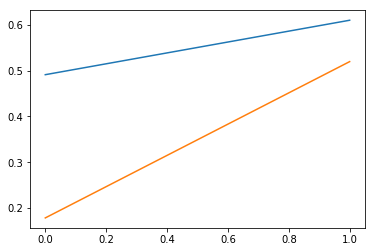

In [1175]:
plt.plot(train_r)
plt.plot(test_r)

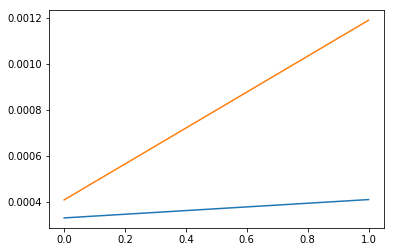

In [1176]:
plt.plot(train_mean_r)
plt.plot(test_mean_r)

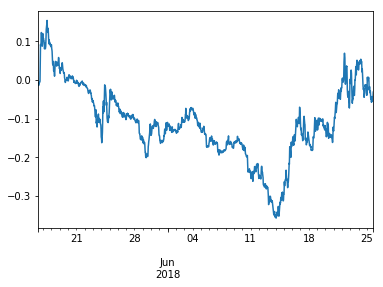

In [1177]:
asset_data[:,:,'diff'].sum(axis=1).cumsum().plot()

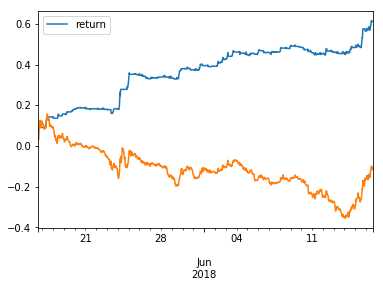

In [1178]:
pd.DataFrame(train_reward,index=asset_data[:,normalize_length:train_length,'diff'].index,columns=['return']).cumsum().plot()
asset_data[:,normalize_length:train_length,'diff'].sum(axis=1).cumsum().plot()

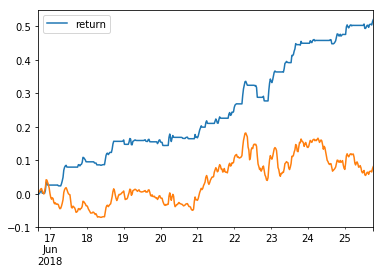

In [1179]:
pd.DataFrame(test_reward,index=asset_data[:,train_length:,'diff'].index,columns=['return']).cumsum().plot()
asset_data[:,train_length:,'diff'].sum(axis=1).cumsum().plot()

In [1180]:
np.sum(test_reward)

0.5196297454629559

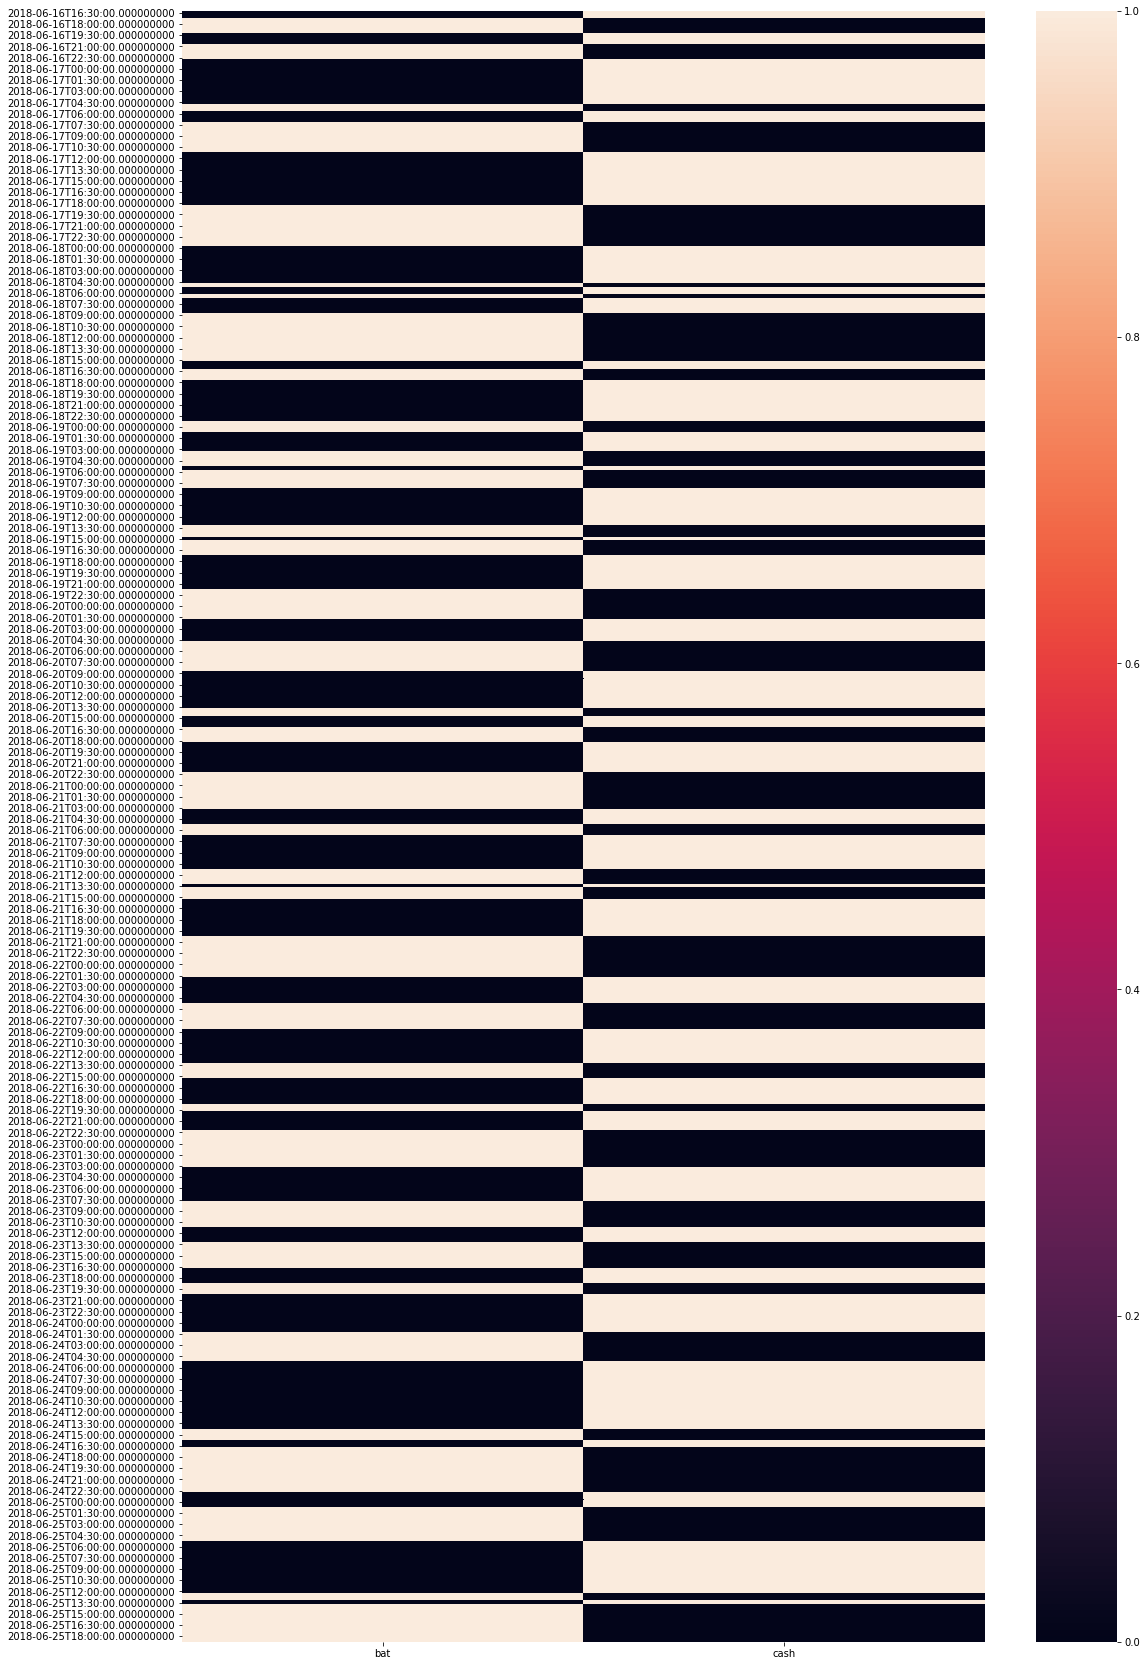

In [1181]:
test_action_df=pd.DataFrame(test_actions,index=asset_data[:,train_length:,'diff'].index,columns=list(asset_data.items)+['cash'])
plt.figure(figsize=(18,30))
sns.heatmap(test_action_df)

In [1208]:
test_length=asset_data.shape[1]-train_length

In [1204]:
def backtest(asset_data, model, test_length,batch_size=30, normalize_length=10, c=1e-4):
    test_reward = []
    test_actions = []
    previous_action=np.zeros(asset_data.shape[0]+1)
    for t in range(asset_data.shape[1]-test_length,asset_data.shape[1]):
        state=asset_data[:,t-normalize_length:t,:].values
        state=state.reshape((state.shape[1],state.shape[0]*state.shape[2]))
        state=z_score(state)[None,-1]
        model.save_current_state(s=state[0])
        action=model.trade(state,train=False,prob=False)
        r=np.sum(asset_data[:,:,'diff'].iloc[t].values*action[:-1]-c*np.sum(np.abs(previous_action-action)))
        test_reward.append(r)
        test_actions.append(action)
        previous_action=action
        if t % batch_size==0:
            model.restore_buffer()
    model.restore_buffer()
    print('back test_reward', np.sum(test_reward))
    return np.sum(test_reward),test_actions,test_reward

In [1205]:
_,test_actions,test_reward=backtest(asset_data,model,test_length=test_length,batch_size=30)

back test_reward 0.5196297454629559


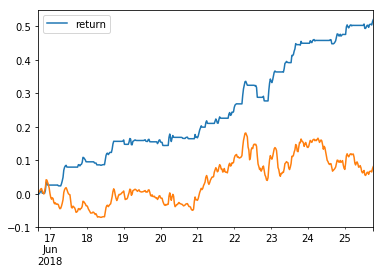

In [1206]:
pd.DataFrame(test_reward,index=asset_data[:,-test_length:,'diff'].index,columns=['return']).cumsum().plot()
asset_data[:,-test_length:,'diff'].sum(axis=1).cumsum().plot()

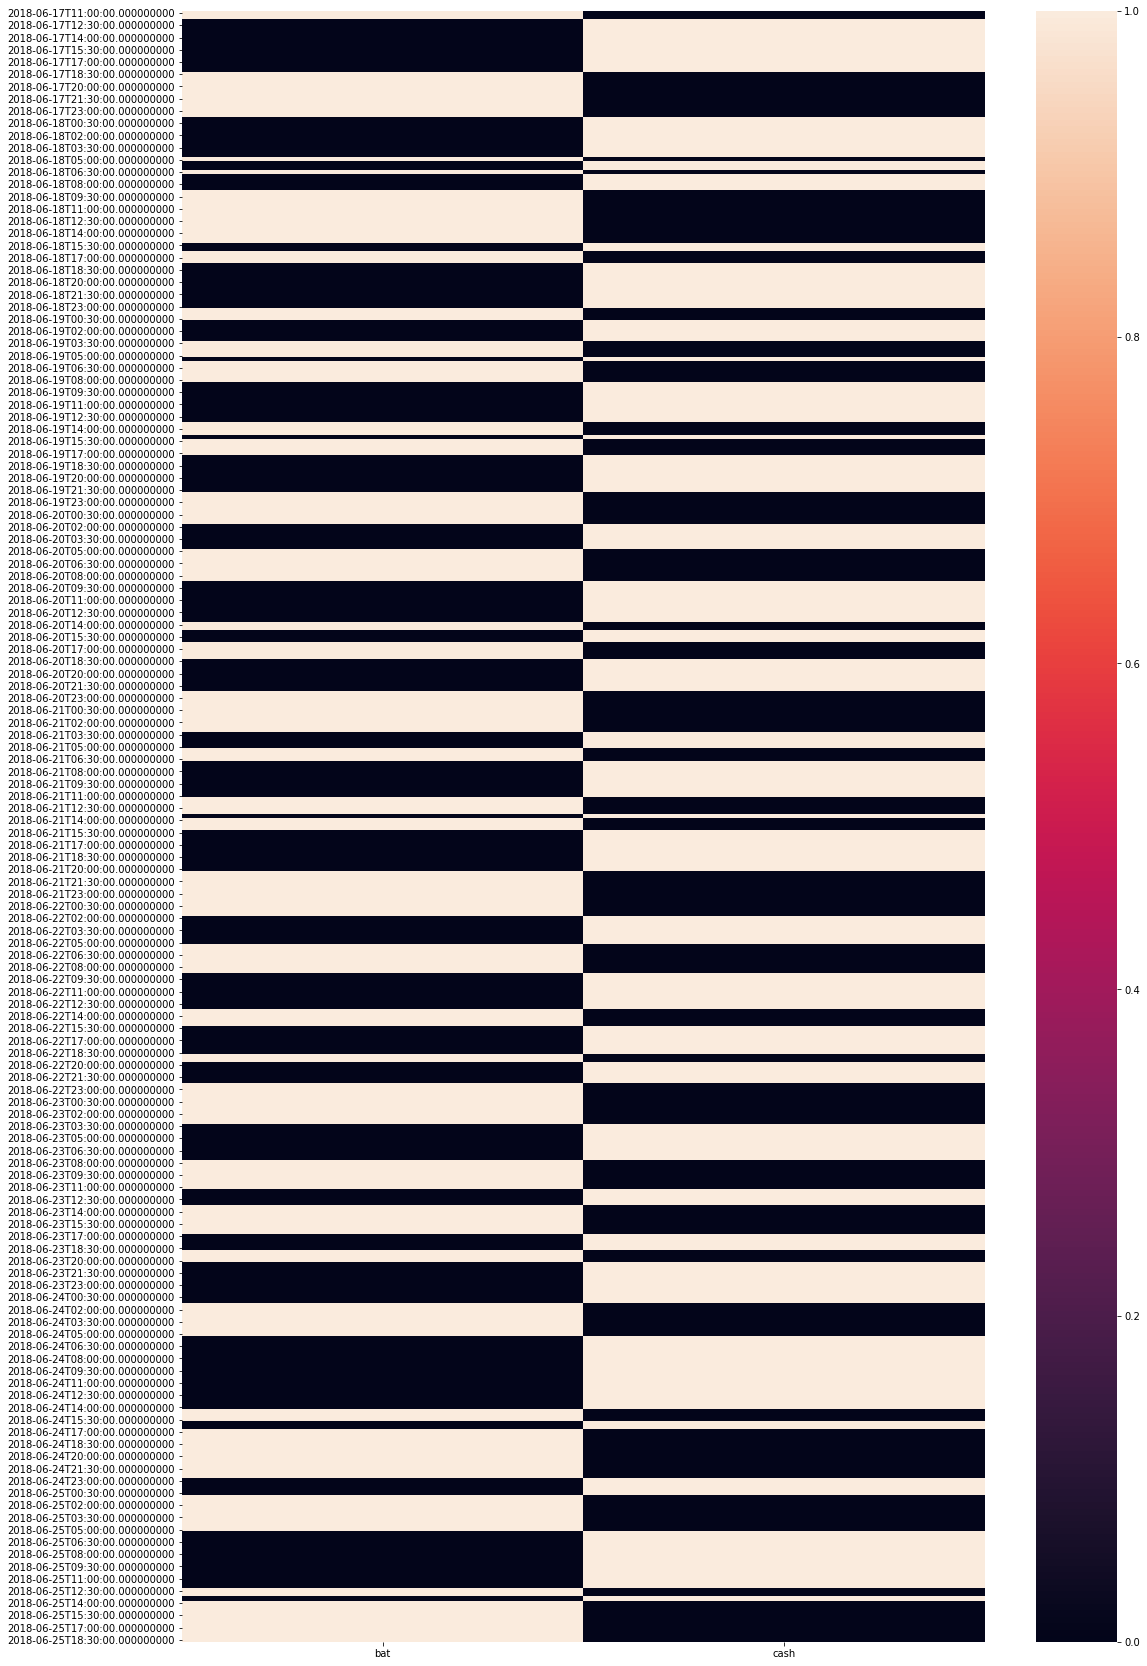

In [1192]:
test_action_df=pd.DataFrame(test_actions,index=asset_data[:,-test_length:,'diff'].index,columns=list(asset_data.items)+['cash'])
plt.figure(figsize=(18,30))
sns.heatmap(test_action_df)

In [1193]:
np.abs(test_action_df.shift(1)-test_action_df).sum()

bat     64.0
cash    64.0
dtype: float64

In [1200]:
def real_trade(asset_data,model, assets, normalize_length=10,batch_size=30, debug=True):
    test_reward = []
    test_actions = []
    previous_action=np.zeros(asset_data.shape[0]+1)
    model.restore_buffer()
    for t in range(asset_data.shape[1]-batch_size,asset_data.shape[1]):
        state=asset_data[:,t-normalize_length+1:t+1,:].values
        state=state.reshape((state.shape[1],state.shape[0]*state.shape[2]))
        state=z_score(state)[None,-1]
        model.save_current_state(s=state[0])
        action=model.trade(state,train=False,prob=False)
    action = list(zip(assets, action[:-1]))
    action = sorted(action, key=lambda x: x[1])
    print('predict action', action)
    return action

In [1201]:
real_trade(asset_data,model,assets=assets)

predict action [('bat', 1.0)]


[('bat', 1.0)]

In [1196]:
model.save_model('./PortfolioTrading/RPG_Portfolio')